In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import numpy as np
import traceback
import sys
import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
import calendar
from calendar import monthrange
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# read the csv input files and raise an exception in case, for example, of typos in file name
try:
    df_sickness=pd.read_csv('sickness_table.csv')
    
except:
    exception_type, exception_value, exception_traceback = sys.exc_info()
    print("Exception Type: {}\nException Value: {}".format(exception_type, exception_value)) 
    file_name, line_number, procedure_name, line_code = traceback.extract_tb(exception_traceback)[-1]   
    print("File Name: {}\nLine Number: {}\nProcedure Name: {}\nLine Code:{}".format(file_name, line_number, 
    procedure_name, line_code))

In [3]:
# explore dataset available features
df_sickness.head(10)

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0
5,5,2016-04-06,70,6492.0,1700,90,0.0,0.0
6,6,2016-04-07,64,6204.0,1700,90,0.0,0.0
7,7,2016-04-08,62,7614.0,1700,90,0.0,0.0
8,8,2016-04-09,51,5706.0,1700,90,0.0,0.0
9,9,2016-04-10,54,6606.0,1700,90,0.0,0.0


In [4]:
df_sickness.shape

(1152, 8)

In [5]:
df_sickness.dtypes

Unnamed: 0      int64
date           object
n_sick          int64
calls         float64
n_duty          int64
n_sby           int64
sby_need      float64
dafted        float64
dtype: object

In [6]:
# Feature engineering: add of "year-month" column to dataframe for visualization purpose
df_sickness['date']= pd.to_datetime(df_sickness['date'],format= '%Y-%m-%d')
df_sickness['year'] = df_sickness['date'].dt.year
df_sickness['month'] = df_sickness['date'].dt.month
df_sickness['month'] = df_sickness['month'].map("{:02}".format)
df_sickness['year'] = df_sickness['year'].astype(str)
df_sickness['month'] = df_sickness['month'].astype(str)
df_sickness['year-month'] = df_sickness[['year','month']].agg("-".join, axis = 1)
df_sickness.dtypes

Unnamed: 0             int64
date          datetime64[ns]
n_sick                 int64
calls                float64
n_duty                 int64
n_sby                  int64
sby_need             float64
dafted               float64
year                  object
month                 object
year-month            object
dtype: object

In [7]:
# Feature engineering: add of "actual number of standy-by drivers needed" and "percentage of activated stand-by drivers"
Dic_sickness= df_sickness.to_numpy()
actual_sby_need = np.add(Dic_sickness[:,6],Dic_sickness[:,7])
activated_sby = np.divide(actual_sby_need,Dic_sickness[:,5])
df_sickness['actual_sby_need'] = actual_sby_need.tolist()
df_sickness['activated_sby'] = activated_sby.tolist()
df_sickness.head(10)

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,year,month,year-month,actual_sby_need,activated_sby
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0,2016,04,2016-04,4.0,0.044444
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0,2016,04,2016-04,70.0,0.777778
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
5,5,2016-04-06,70,6492.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
6,6,2016-04-07,64,6204.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
7,7,2016-04-08,62,7614.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
8,8,2016-04-09,51,5706.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000
9,9,2016-04-10,54,6606.0,1700,90,0.0,0.0,2016,04,2016-04,0.0,0.000000


In [8]:
# Calculate Pearson's correlation between features to understand their relevance
Dic_sickness= df_sickness.to_numpy()
corr1 = pearsonr(Dic_sickness[:,3], Dic_sickness[:,6])
corr2 = pearsonr(Dic_sickness[:,3], Dic_sickness[:,7])
corr3 = pearsonr(Dic_sickness[:,3], Dic_sickness[:,2])
corr4 = pearsonr(Dic_sickness[:,2], Dic_sickness[:,6])
corr5 = pearsonr(Dic_sickness[:,3], Dic_sickness[:,11])
corr6 = pearsonr(Dic_sickness[:,6], Dic_sickness[:,7])
corr7 = pearsonr(Dic_sickness[:,2], Dic_sickness[:,11])

print ("Pearson's correlation between 'calls' and 'sby_need' is:  ", corr1[0])
print ("Pearson's correlation between 'calls' and 'dafted' is:  ", corr2[0])
print ("Pearson's correlation between 'calls' and 'n_sick' is:  ", corr3[0])
print ("Pearson's correlation between 'n_sick' and 'sby_need' is:  ", corr4[0])
print ("Pearson's correlation between 'calls' and 'actual_sby_need' is:  ", corr5[0])
print ("Pearson's correlation between 'sby_need' and 'dafted' is:  ", corr6[0])
print ("Pearson's correlation between 'n_sick' and 'actual_sby_need' is:  ", corr7[0])

Pearson's correlation between 'calls' and 'sby_need' is:   0.677467517263761
Pearson's correlation between 'calls' and 'dafted' is:   0.5573397071763648
Pearson's correlation between 'calls' and 'n_sick' is:   0.15537086860280808
Pearson's correlation between 'n_sick' and 'sby_need' is:   0.02232140685865095
Pearson's correlation between 'calls' and 'actual_sby_need' is:   0.6377298422728717
Pearson's correlation between 'sby_need' and 'dafted' is:   0.9451676217096112
Pearson's correlation between 'n_sick' and 'actual_sby_need' is:   0.02037654016751976


In [9]:
# Pivot the dataframe on "year-month" for visualization purpose"
df_sickness_pivot = pd.pivot_table(df_sickness, values = ["n_sick","calls","n_sby","sby_need","dafted","actual_sby_need"], index = ['year-month'], aggfunc = np.sum)
df_sickness_pivot

,actual_sby_need,calls,dafted,n_sby,n_sick,sby_need
year-month,,,,,,
2016-04,170.0,203280.0,3.0,2700,1840,167.0
2016-05,710.0,238164.0,116.0,2790,1738,594.0
2016-06,2150.0,236046.0,639.0,2700,1666,1511.0
2016-07,2232.0,237144.0,671.0,2790,1757,1561.0
2016-08,3500.0,245178.0,1313.0,2790,1450,2187.0
2016-09,1391.0,230268.0,303.0,2700,2172,1088.0
2016-10,93.0,216894.0,0.0,2790,2345,93.0
2016-11,540.0,205398.0,195.0,2700,1825,345.0
2016-12,34.0,196908.0,0.0,2790,1868,34.0


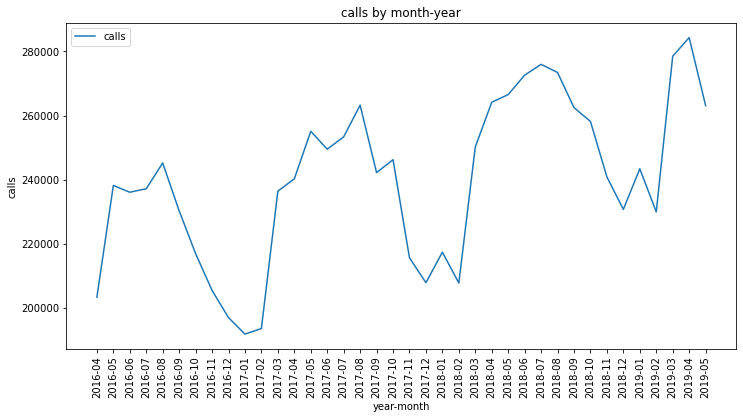

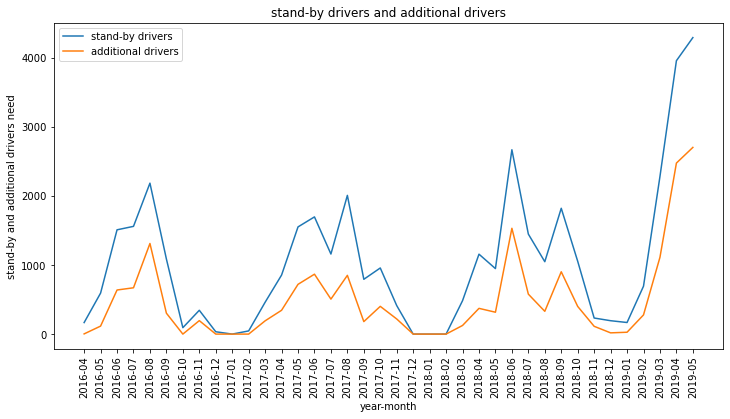

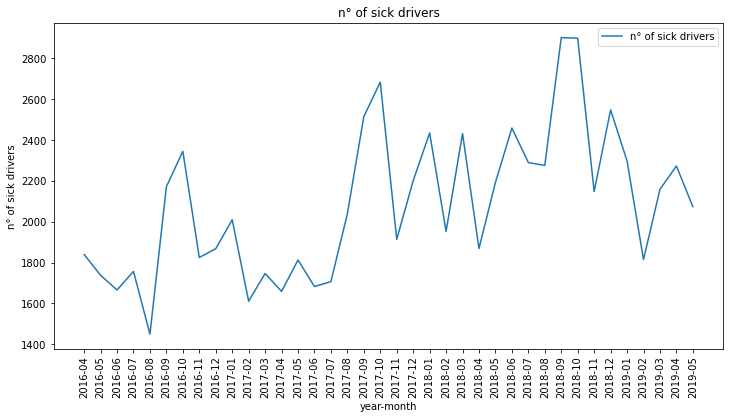

In [10]:
#visualize relationship between most relevant features
df_sickness_pivot['year-month'] = df_sickness_pivot.index
Dic_sickness_pivot = df_sickness_pivot.to_numpy()

def graphs():
    ''' 
    This function shows relationships between ideal and train functions using line charts
    
    Parameters:
    ------------
    First plot:
    x: year-month
    y: number of calls
    return: a line chart
    
    Second plot:
    x: year-month
    y: stand-by-drivers, additional drivers
    return: a line chart
    
    Third plot:
    x: year-month
    y: n° of sick drivers
    return: a line chart
    
    '''
    #1 First plot
    plt.figure(figsize=(12,6))
    plt.plot(Dic_sickness_pivot[:,6],Dic_sickness_pivot[:,1])
    plt.title("calls by month-year")
    plt.xticks(rotation='vertical')
    plt.xlabel("year-month")
    plt.ylabel("calls")
    plt.legend(['calls'])
    plt.show
    #2 Second plot
    plt.figure(figsize=(12,6))
    plt.plot(Dic_sickness_pivot[:,6],Dic_sickness_pivot[:,5], label = "stand-by drivers")
    plt.plot(Dic_sickness_pivot[:,6],Dic_sickness_pivot[:,2], label = "additional drivers")
    plt.title("stand-by drivers and additional drivers")
    plt.xticks(rotation='vertical')
    plt.xlabel("year-month")
    plt.ylabel("stand-by and additional drivers need")
    plt.legend()
    plt.show
    #3 Third plot
    plt.figure(figsize=(12,6))
    plt.plot(Dic_sickness_pivot[:,6],Dic_sickness_pivot[:,4])
    plt.title("n° of sick drivers")
    plt.xticks(rotation='vertical')
    plt.xlabel("year-month")
    plt.ylabel("n° of sick drivers")
    plt.legend(['n° of sick drivers'])
    plt.show

graphs()

In [11]:
# create a new dataframe with the target variable "actual sby need"
df_sickness_model=pd.DataFrame({'year-month':Dic_sickness_pivot[:,6],'actual sby need':Dic_sickness_pivot[:,0]})
df_sickness_model['actual sby need']=df_sickness_model['actual sby need'].astype(float)
df_sickness_model.head(10)

,year-month,actual sby need
0,2016-04,170.0
1,2016-05,710.0
2,2016-06,2150.0
3,2016-07,2232.0
4,2016-08,3500.0
5,2016-09,1391.0
6,2016-10,93.0
7,2016-11,540.0
8,2016-12,34.0
9,2017-01,0.0


In [12]:
# split the dataset into train and test after removing outliers
df_sickness_model_outliers = df_sickness_model[df_sickness_model['year-month'].isin(["2019-04","2019-05"])]
df_sickness_model_test = df_sickness_model[df_sickness_model['year-month'].isin(["2018-04","2018-05","2018-06","2018-07","2018-08","2018-09","2018-10","2018-11","2018-12","2019-01","2019-02","2019-03"])]
df_sickness_model_train = df_sickness_model[df_sickness_model['year-month'].isin(["2016-04","2016-05","2016-06","2016-07","2016-08","2016-09","2016-10","2016-11","2016-12","2017-01","2017-02","2017-03","2017-04","2017-05","2017-06","2017-07","2017-08","2017-09","2017-10","2017-11","2017-12","2018-01","2018-02","2018-03"])]
print ("Train dataset is ", len(df_sickness_model_train)/len(df_sickness_model), " of total dataset")
print ("Teain dataset is ", len(df_sickness_model_test)/len(df_sickness_model), " of total dataset")
print ("Outliers are ", len(df_sickness_model_outliers)/len(df_sickness_model), " of total dataset")

Train dataset is  0.631578947368421  of total dataset
Teain dataset is  0.3157894736842105  of total dataset
Outliers are  0.05263157894736842  of total dataset


In [13]:
# add month and year columns for modeling purpose
df_sickness_model_train['month'] = [x[-2:] for x in df_sickness_model_train['year-month']]
df_sickness_model_train['year'] = [x[:4] for x in df_sickness_model_train['year-month']]
df_sickness_model_test['month'] = [x[-2:] for x in df_sickness_model_test['year-month']]

In [14]:
# 1st model try: model "actual sby need" on AVERAGE stand-by drivers need by month 
df_sickness_model_train_pivot = pd.pivot_table(df_sickness_model_train, values = ["actual sby need"], index = ['month'], 
                                               aggfunc = np.average)
df_sickness_model_train_pivot

,actual sby need
month,
01,0.0
02,23.0
03,631.0
04,685.0
05,1492.0
06,2358.0
07,1949.5
08,3180.5
09,1183.0


In [15]:
# store average stand-by drivers need in an array
df_sickness_model_train_pivot['month'] = df_sickness_model_train_pivot.index
df_sickness_model_train_pivot = df_sickness_model_train_pivot[list(("month","actual sby need"))]
Dic_train_average = df_sickness_model_train_pivot.to_numpy()

In [16]:
# store test outputs in an array
df_sickness_model_test = df_sickness_model_test.drop(['year-month'], axis=1)
df_sickness_model_test = df_sickness_model_test[list(("month","actual sby need"))]
df_sickness_model_test = df_sickness_model_test.sort_values(by=['month'])
Dic_test = df_sickness_model_test.to_numpy()

In [17]:
# 2nd model try: model "actual sby need" on LINEAR REGRESSION of stand by drivers need by month
df_sickness_model_train = df_sickness_model_train.sort_values(by=['month','year'])
df_sickness_model_train

,year-month,actual sby need,month,year
9,2017-01,0.0,01,2017
21,2018-01,0.0,01,2018
10,2017-02,46.0,02,2017
22,2018-02,0.0,02,2018
11,2017-03,653.0,03,2017
23,2018-03,609.0,03,2018
0,2016-04,170.0,04,2016
12,2017-04,1200.0,04,2017
1,2016-05,710.0,05,2016
13,2017-05,2274.0,05,2017


In [18]:
# split the dataframe into month dataframes
df_sickness_model_train['year']=df_sickness_model_train['year'].astype(int)
df_sickness_model_train_jan = df_sickness_model_train[df_sickness_model_train['month'].isin(["01"])]
df_sickness_model_train_feb = df_sickness_model_train[df_sickness_model_train['month'].isin(["02"])]
df_sickness_model_train_mar = df_sickness_model_train[df_sickness_model_train['month'].isin(["03"])]
df_sickness_model_train_apr = df_sickness_model_train[df_sickness_model_train['month'].isin(["04"])]
df_sickness_model_train_may = df_sickness_model_train[df_sickness_model_train['month'].isin(["05"])]
df_sickness_model_train_jun = df_sickness_model_train[df_sickness_model_train['month'].isin(["06"])]
df_sickness_model_train_jul = df_sickness_model_train[df_sickness_model_train['month'].isin(["07"])]
df_sickness_model_train_aug = df_sickness_model_train[df_sickness_model_train['month'].isin(["08"])]
df_sickness_model_train_sep = df_sickness_model_train[df_sickness_model_train['month'].isin(["09"])]
df_sickness_model_train_oct = df_sickness_model_train[df_sickness_model_train['month'].isin(["10"])]
df_sickness_model_train_nov = df_sickness_model_train[df_sickness_model_train['month'].isin(["11"])]
df_sickness_model_train_dec = df_sickness_model_train[df_sickness_model_train['month'].isin(["12"])]
Dic_train_lr_jan = df_sickness_model_train_jan.to_numpy()
Dic_train_lr_feb = df_sickness_model_train_feb.to_numpy()
Dic_train_lr_mar = df_sickness_model_train_mar.to_numpy()
Dic_train_lr_apr = df_sickness_model_train_apr.to_numpy()
Dic_train_lr_may = df_sickness_model_train_may.to_numpy()
Dic_train_lr_jun = df_sickness_model_train_jun.to_numpy()
Dic_train_lr_jul = df_sickness_model_train_jul.to_numpy()
Dic_train_lr_aug = df_sickness_model_train_aug.to_numpy()
Dic_train_lr_sep = df_sickness_model_train_sep.to_numpy()
Dic_train_lr_oct = df_sickness_model_train_oct.to_numpy()
Dic_train_lr_nov = df_sickness_model_train_nov.to_numpy()
Dic_train_lr_dec = df_sickness_model_train_dec.to_numpy()

In [19]:
# calculate linear regression for each month and store in in array
ml_model = LinearRegression()

X_jan= Dic_train_lr_jan[:,3].reshape((-1,1))
ml_model.fit(X_jan,Dic_train_lr_jan[:,1])
Year_to_predict_jan = Dic_train_lr_jan[-1][3]+1
X_jan_pred = np.array([Year_to_predict_jan]).reshape((-1,1))
pred_jan = ml_model.predict(X_jan_pred)


X_feb= Dic_train_lr_feb[:,3].reshape((-1,1))
ml_model.fit(X_feb,Dic_train_lr_feb[:,1])
Year_to_predict = Dic_train_lr_feb[-1][3]+1
X_feb_pred = np.array([Year_to_predict]).reshape((-1,1))
pred_feb = ml_model.predict(X_feb_pred)

X_mar= Dic_train_lr_mar[:,3].reshape((-1,1))
ml_model.fit(X_mar,Dic_train_lr_mar[:,1])
Year_to_predict_mar = Dic_train_lr_mar[-1][3]+1
X_mar_pred = np.array([Year_to_predict_mar]).reshape((-1,1))
pred_mar = ml_model.predict(X_mar_pred)

X_apr= Dic_train_lr_apr[:,3].reshape((-1,1))
ml_model.fit(X_apr,Dic_train_lr_apr[:,1])
Year_to_predict_apr = Dic_train_lr_apr[-1][3]+1
X_apr_pred = np.array([Year_to_predict_apr]).reshape((-1,1))
pred_apr = ml_model.predict(X_apr_pred)

X_may= Dic_train_lr_may[:,3].reshape((-1,1))
ml_model.fit(X_may,Dic_train_lr_may[:,1])
Year_to_predict_may = Dic_train_lr_may[-1][3]+1
X_may_pred = np.array([Year_to_predict_may]).reshape((-1,1))
pred_may = ml_model.predict(X_may_pred)

X_jun= Dic_train_lr_jun[:,3].reshape((-1,1))
ml_model.fit(X_jun,Dic_train_lr_jun[:,1])
Year_to_predict_jun = Dic_train_lr_jun[-1][3]+1
X_jun_pred = np.array([Year_to_predict_jun]).reshape((-1,1))
pred_jun = ml_model.predict(X_jun_pred)

X_jul= Dic_train_lr_jul[:,3].reshape((-1,1))
ml_model.fit(X_jul,Dic_train_lr_jul[:,1])
Year_to_predict_jul = Dic_train_lr_jul[-1][3]+1
X_jul_pred = np.array([Year_to_predict_jul]).reshape((-1,1))
pred_jul = ml_model.predict(X_jul_pred)

X_aug= Dic_train_lr_aug[:,3].reshape((-1,1))
ml_model.fit(X_aug,Dic_train_lr_aug[:,1])
Year_to_predict_aug = Dic_train_lr_aug[-1][3]+1
X_aug_pred = np.array([Year_to_predict_aug]).reshape((-1,1))
pred_aug = ml_model.predict(X_aug_pred)

X_sep= Dic_train_lr_sep[:,3].reshape((-1,1))
ml_model.fit(X_sep,Dic_train_lr_sep[:,1])
Year_to_predict_sep = Dic_train_lr_sep[-1][3]+1
X_sep_pred = np.array([Year_to_predict_sep]).reshape((-1,1))
pred_sep = ml_model.predict(X_sep_pred)

X_oct= Dic_train_lr_oct[:,3].reshape((-1,1))
ml_model.fit(X_oct,Dic_train_lr_oct[:,1])
Year_to_predict_oct = Dic_train_lr_oct[-1][3]+1
X_oct_pred = np.array([Year_to_predict_oct]).reshape((-1,1))
pred_oct = ml_model.predict(X_oct_pred)

X_nov= Dic_train_lr_nov[:,3].reshape((-1,1))
ml_model.fit(X_nov,Dic_train_lr_nov[:,1])
Year_to_predict_nov = Dic_train_lr_nov[-1][3]+1
X_nov_pred = np.array([Year_to_predict_nov]).reshape((-1,1))
pred_nov = ml_model.predict(X_nov_pred)

X_dec= Dic_train_lr_dec[:,3].reshape((-1,1))
ml_model.fit(X_dec,Dic_train_lr_dec[:,1])
Year_to_predict_dec = Dic_train_lr_dec[-1][3]+1
X_dec_pred = np.array([Year_to_predict_dec]).reshape((-1,1))
pred_dec = ml_model.predict(X_dec_pred)

Dic_train_lr = np.array([pred_jan, pred_feb, pred_mar, pred_apr, pred_may, pred_jun, pred_jul, 
                         pred_aug, pred_sep, pred_oct, pred_nov, pred_dec])


In [20]:
# compare AVERAGE and LINEAR REGRESSION performances with MSE and MAE
dic_std_90 = np.array([90,90,90,90,90,90,90,90,90,90,90,90])
mse_act = mean_squared_error(Dic_test[:,1], dic_std_90)
mae_act = mean_absolute_error(Dic_test[:,1], dic_std_90)
mse_avg = mean_squared_error(Dic_test[:,1], Dic_train_average[:,1])
mae_avg = mean_absolute_error(Dic_test[:,1], Dic_train_average[:,1])
mse_lr = mean_squared_error(Dic_test[:,1], Dic_train_lr)
mae_lr = mean_absolute_error(Dic_test[:,1], Dic_train_lr)

print ("Actual configuration of 90 stand-by drivers has an MSE of ", mse_act, "while MAE is ", mae_act)
print ("Considering average as predictor MSE is ", mse_avg, " while MAE is ", mae_avg)
print ("Considering linear regression as predictor MSE is ", mse_lr, " while MAE is ", mae_lr)
print ("Using average produces better performances and can be considered as a baseline benchmark model.")
print ("Compared to actual configuration, average predictor decreased MSE of", round((mse_avg-mse_act)/mse_act,2)*100, "%")

Actual configuration of 90 stand-by drivers has an MSE of  3868490.6666666665 while MAE is  1552.6666666666667
Considering average as predictor MSE is  1585341.5625  while MAE is  951.2916666666666
Considering linear regression as predictor MSE is  2127524.75  while MAE is  1189.0833333333333
Using average produces better performances and can be considered as a baseline benchmark model.
Compared to actual configuration, average predictor decreased MSE of -59.0 %


In [21]:
df_sickness_model['month'] = [x[-2:] for x in df_sickness_model['year-month']]
df_sickness_model['year'] = [x[:4] for x in df_sickness_model['year-month']]

In [22]:
# considering the small dataframes extend to all dataset(train+test-outlier) for prediction based on AVERAGE
df_sickness_model_cleaned = df_sickness_model[df_sickness_model["year-month"].isin(["2019-04","2019-05"]) == False]

In [25]:
# prediction of June, for example, can be run by 15th May
month_to_predict = input("Insert the number of the month to predict ")

Insert the number of the month to predict 06


In [26]:
# prediction output
df_predictor = df_sickness_model_cleaned[df_sickness_model_cleaned['month'].isin([month_to_predict])]
month_to_predict = int(month_to_predict)
month_nam = calendar.month_name[month_to_predict]
df_predictor['year'] = df_predictor['year'].astype(int)
dic_predictor = df_predictor.to_numpy()
year_to_predict = dic_predictor[-1][3]+1
month_days = monthrange(year_to_predict, month_to_predict)[1]
daily_sby_drivers_needed = round(df_predictor['actual sby need'].mean()/month_days,0)
if daily_sby_drivers_needed < 10 :
    daily_sby_drivers_needed = 10.0
print ("The predicted number of daily stand-by drivers needed for the month of", month_nam, "in year" , 
       year_to_predict, "is", daily_sby_drivers_needed)





The predicted number of daily stand-by drivers needed for the month of June in year 2019 is 99.0


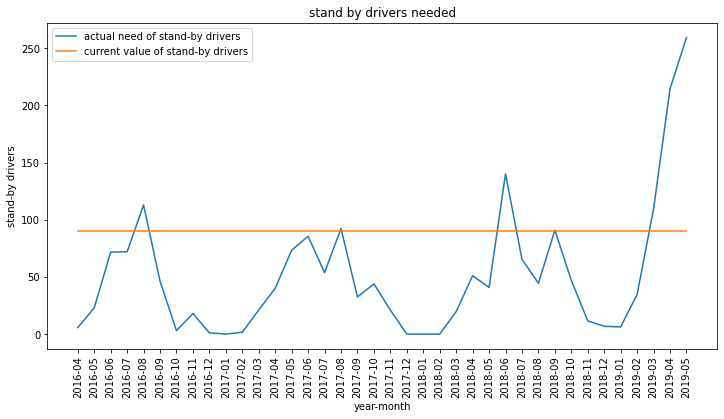

In [27]:
# prediction of June'19, for example, makes sense since it one of the months that needs more stand-by drivers 
df_sickness_actual = pd.pivot_table(df_sickness, values = ["actual_sby_need"], index = ['year-month'], aggfunc = np.average)
df_sickness_actual['year-month'] = df_sickness_actual.index
Dic_sickness_actual = df_sickness_actual.to_numpy()
current_threshold = np.array([90 for i in range(len(Dic_sickness_actual[:,0]))])

plt.figure(figsize=(12,6))
plt.plot(Dic_sickness_actual[:,1],Dic_sickness_actual[:,0], label = "actual need of stand-by drivers")
plt.plot(Dic_sickness_actual[:,1],current_threshold, label = "current value of stand-by drivers")
plt.title("stand by drivers needed")
plt.xticks(rotation='vertical')
plt.xlabel("year-month")
plt.ylabel("stand-by drivers")
plt.legend()

In [28]:
# define a GUI for prediction on AVERAGE baseline model
import tkinter as tk

def drivers_need() :
    ''' 
    This function returns the prediction based on AVERAGE model in 1 year horizont for the GUI.
    
    '''    
    month_to_predict = input_month.get()
    threshold = input_threshold.get()
    df_predictor = df_sickness_model_cleaned[df_sickness_model_cleaned['month'].isin([month_to_predict])]
    month_to_predict = int(month_to_predict)
    month_name = calendar.month_name[month_to_predict]
    df_predictor['year'] = df_predictor['year'].astype(int)
    dic_predictor = df_predictor.to_numpy()
    year_to_predict = dic_predictor[-1][3]+1
    month_days = monthrange(year_to_predict, month_to_predict)[1]
    daily_sby_drivers_needed = round(df_predictor['actual sby need'].mean()/month_days,0)
    if daily_sby_drivers_needed < float(threshold) :
        daily_sby_drivers_needed = float(threshold)
    lbl_result["text"] = f"Daily need is {daily_sby_drivers_needed} stand-by drivers"
    
    

window = tk.Tk()
window.title("Daily standy by drivers need predictor")
frm_entry = tk.Frame(master = window)
label = tk.Label(master = frm_entry, text="Insert below the number of the month you want to predict", fg = "white", 
                 bg = "black", width = 70, height = 3)
input_month = tk.Entry(master = frm_entry, fg = "black", bg = "white", width = 50)
label_2 = tk.Label(master = frm_entry, text="How many minimum stand by drivers do you want to have?", fg = "white", 
                 bg = "black", width = 70, height = 3)
input_threshold = tk.Entry(master = frm_entry, fg = "black", bg = "white", width = 50)
label.grid(row=0, column=0, padx = 5, pady = 5)
input_month.grid(row=1, column=0, padx = 5, pady = 5)
label_2.grid(row=2, column=0, padx = 5, pady = 5)
input_threshold.grid(row=3, column=0, padx = 5, pady = 5)

btn_predictor = tk.Button(master = window, text = "Calculate", command = drivers_need)
lbl_result = tk.Label(master=window)
frm_entry.grid(row = 0, column = 0, padx = 10)
btn_predictor.grid(row = 0, column = 1, padx = 10)
lbl_result.grid(row = 0, column = 2, padx= 10)
window.mainloop()

In [29]:
# after defining a baseline model, let's create a more sophisticated prediction model based on SARIMA
df_sickness_model_train = df_sickness_model_train.sort_values(by=['year','month'])
df_sickness_model_train = df_sickness_model_train.set_index('year-month')
# create the train dataset as a time-series
ts = df_sickness_model_train['actual sby need']
ts

year-month
2016-04     170.0
2016-05     710.0
2016-06    2150.0
2016-07    2232.0
2016-08    3500.0
2016-09    1391.0
2016-10      93.0
2016-11     540.0
2016-12      34.0
2017-01       0.0
2017-02      46.0
2017-03     653.0
2017-04    1200.0
2017-05    2274.0
2017-06    2566.0
2017-07    1667.0
2017-08    2861.0
2017-09     975.0
2017-10    1360.0
2017-11     632.0
2017-12       0.0
2018-01       0.0
2018-02       0.0
2018-03     609.0
Name: actual sby need, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

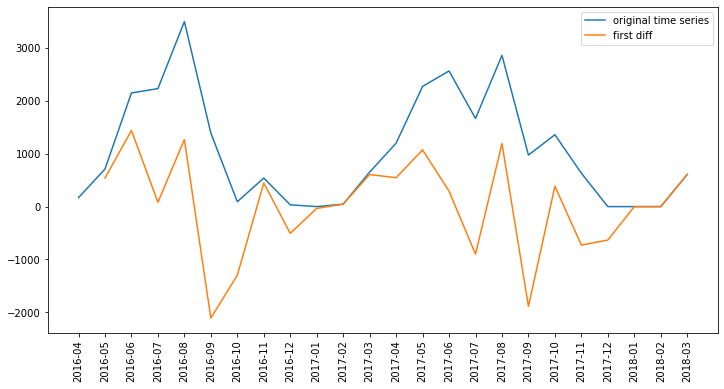

In [30]:
# define if the time series seems to be stationary, first difference is stationary
plt.figure(figsize=(12,6))
plt.plot(ts, label = "original time series")
plt.xticks(rotation='vertical')
plt.legend()
plt.show

first_diff = ts.diff()[1:]
plt.plot(first_diff, label = "first diff")
plt.xticks(rotation='vertical')
plt.legend()
plt.show

<BarContainer object of 20 artists>

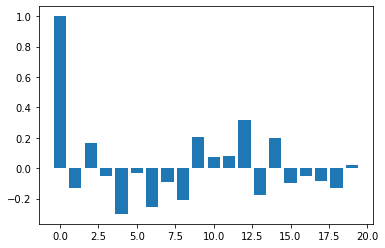

In [31]:
# use ACF to determine "p"
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 10 artists>

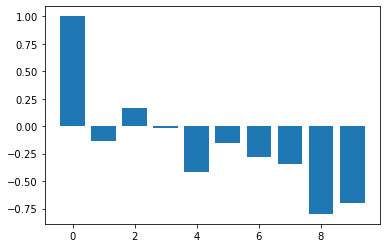

In [32]:
# use PACF to determine "q"
pacf_vals = pacf(first_diff, nlags =10)
num_lags = 10
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [33]:
# define (p,d,q) and (P,D,Q,s) and fit the model
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
model = SARIMAX(ts, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                      actual sby need   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -186.655
Date:                              Sat, 04 Dec 2021   AIC                            379.310
Time:                                      19:32:09   BIC                            382.717
Sample:                                  04-01-2016   HQIC                           380.167
                                       - 03-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9550      0.154      6.187      0.000       0.652       1.258
ma.S.L12      -0.64

In [34]:
predictions = model_fit.forecast(len(Dic_test))

In [35]:
df_predictions = pd.DataFrame(predictions)
df_predictions['year-month'] =df_predictions.index
df_predictions['month'] = df_predictions['year-month'].dt.month
df_predictions['year'] = df_predictions['year-month'].dt.year
df_predictions = df_predictions.sort_values(by=['month'])
Dic_train_sarima = df_predictions.to_numpy()

In [36]:
# evaluate SARIMA performances using MSE and MAE, results are better than AVERAGE baseline method
mse_sarima = mean_squared_error(Dic_test[:,1], Dic_train_sarima[:,0])
mae_sarima = mean_absolute_error(Dic_test[:,1], Dic_train_sarima[:,0])
print ("Considering SARIMA as predictor MSE is ", mse_sarima, " while MAE is ", mae_sarima)
print ("Compared to actual configuration, SARIMA predictor decreased MSE of", round((mse_sarima-mse_act)/mse_act,2)*100, "%")

Considering SARIMA as predictor MSE is  1327312.859724742  while MAE is  865.8746457139499
Compared to actual configuration, SARIMA predictor decreased MSE of -66.0 %


In [37]:
# as done for AVERAGE baseline model, considering the small dataset,the model is retrained considering a larger
# dataset and parameters are re-defined
df_sickness_model_cleaned = df_sickness_model_cleaned.sort_values(by=['year','month'])
df_sickness_model_cleaned = df_sickness_model_cleaned.set_index('year-month')
ts = df_sickness_model_cleaned['actual sby need']
ts.tail()

year-month
2018-11     346.0
2018-12     212.0
2019-01     195.0
2019-02     972.0
2019-03    3397.0
Name: actual sby need, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

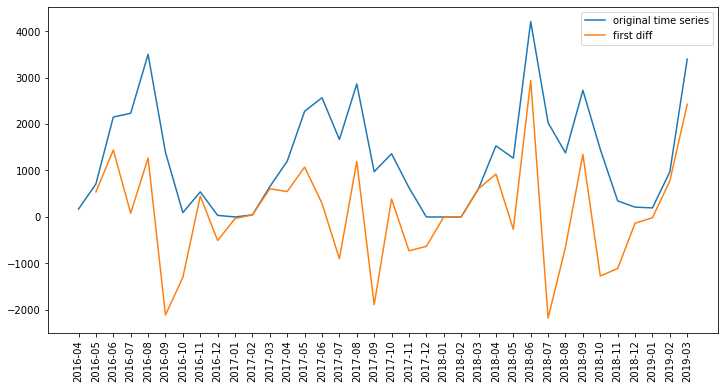

In [38]:
# let's replot time series and first_difference, now also original time series "ts" seems to be more stationary
plt.figure(figsize=(12,6))
plt.plot(ts, label = "original time series")
plt.xticks(rotation='vertical')
plt.legend()
plt.show

first_diff = ts.diff()[1:]
plt.plot(first_diff, label = "first diff")
plt.xticks(rotation='vertical')
plt.legend()
plt.show


In [39]:
# Let's do a test on stationarity on original time series "ts"
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    ''' 
    This function evaluates if the time series is stationary or not.
    
    '''
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

In [40]:
ts_diff = pd.Series(ts)
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is stationary


In [41]:
d

0

<BarContainer object of 20 artists>

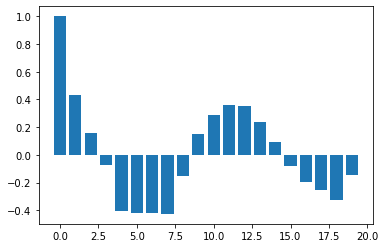

In [42]:
# After defining that in this case "d" will be 0, let's check "p" and "q" on original time series "ts" (not anymore 
# on "first_diff")
acf_vals = acf(ts)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 11 artists>

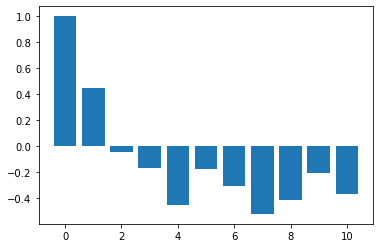

In [43]:
pacf_vals = pacf(ts, nlags = 11)
num_lags = 11
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [44]:
# re-train the model with new parameters
my_order = (0,0,0)
my_seasonal_order = (1, 0, 1, 12)
model = SARIMAX(ts, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:            actual sby need   No. Observations:                   36
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -305.539
Date:                    Sat, 04 Dec 2021   AIC                            617.078
Time:                            19:32:23   BIC                            621.829
Sample:                        04-01-2016   HQIC                           618.737
                             - 03-01-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8558      0.197      4.353      0.000       0.471       1.241
ma.S.L12      -0.0904      0.627     -0.144      0.885      -1.318       1.138
sigma2      9.347e+0

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [45]:
predictions = model_fit.forecast(len(Dic_test))

In [46]:
df_predictions = pd.DataFrame(predictions)
df_predictions['year-month'] =df_predictions.index
df_predictions['month'] = df_predictions['year-month'].dt.month
df_predictions['year'] = df_predictions['year-month'].dt.year

In [47]:
df_predictions = pd.DataFrame(predictions)
df_predictions['year-month'] =df_predictions.index
df_predictions['month'] = df_predictions['year-month'].dt.month
df_predictions['year'] = df_predictions['year-month'].dt.year
df_predictions = df_predictions.sort_values(by=['month'])
Dic_train_sarima = df_predictions.to_numpy()

In [48]:
# re-evaluate SARIMA performances using MSE and MAE, results are much better than AVERAGE baseline method
mse_sarima = mean_squared_error(Dic_test[:,1], Dic_train_sarima[:,0])
mae_sarima = mean_absolute_error(Dic_test[:,1], Dic_train_sarima[:,0])
print ("Considering SARIMA as predictor MSE is ", mse_sarima, " while MAE is ", mae_sarima)

Considering SARIMA as predictor MSE is  154312.12488978627  while MAE is  297.26608040924856


<function matplotlib.pyplot.show(close=None, block=None)>

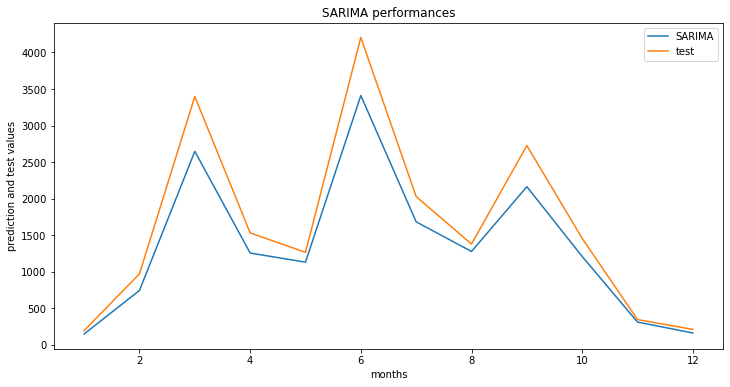

In [49]:
# plot test and prediction
# predictions follow test dataset, that makes sense since now it's included in the the train dataset
# predictions for next year are always slight lower than test dataset since they consider also past seasons; 
# it makes sense as well

plt.figure(figsize=(12,6))
plt.plot(range(1,13),Dic_train_sarima[:,0], label = "SARIMA")
plt.plot(range(1,13),Dic_test[:,1], label = "test")
plt.title("SARIMA performances")
plt.xlabel("months")
plt.ylabel("prediction and test values")
plt.legend()
plt.show

In [ ]:
# define a GUI for prediction on SARIMA predictive model
import tkinter as tk

def drivers_need() :
    ''' 
    This function now returns the prediction based on SARIMA model in 1 year horizont for the GUI.
    
    '''
    month_to_predict = input_month.get()
    threshold = input_threshold.get()
    month_to_predict = int(month_to_predict)
    df_predictor = df_predictions[df_predictions['month'].isin([month_to_predict])]
    month_name = calendar.month_name[month_to_predict]
    dic_predictor = df_predictor.to_numpy()
    year_to_predict = dic_predictor[-1][3]+1
    month_days = monthrange(year_to_predict, month_to_predict)[1]
    daily_sby_drivers_needed = round(df_predictor['predicted_mean'][0]/month_days,0)
    if daily_sby_drivers_needed < float(threshold) :
        daily_sby_drivers_needed = float(threshold)
    lbl_result["text"] = f"Daily need is {daily_sby_drivers_needed} stand-by drivers"
    
    

window = tk.Tk()
window.title("Daily standy by drivers need predictor")
frm_entry = tk.Frame(master = window)
label = tk.Label(master = frm_entry, text="Insert below the number of the month you want to predict", fg = "white", 
                 bg = "black", width = 70, height = 3)
input_month = tk.Entry(master = frm_entry, fg = "black", bg = "white", width = 50)
label_2 = tk.Label(master = frm_entry, text="How many minimum stand by drivers do you want to have?", fg = "white", 
                 bg = "black", width = 70, height = 3)
input_threshold = tk.Entry(master = frm_entry, fg = "black", bg = "white", width = 50)
label.grid(row=0, column=0, padx = 5, pady = 5)
input_month.grid(row=1, column=0, padx = 5, pady = 5)
label_2.grid(row=2, column=0, padx = 5, pady = 5)
input_threshold.grid(row=3, column=0, padx = 5, pady = 5)

btn_predictor = tk.Button(master = window, text = "Calculate", command = drivers_need)
lbl_result = tk.Label(master=window)
frm_entry.grid(row = 0, column = 0, padx = 10)
btn_predictor.grid(row = 0, column = 1, padx = 10)
lbl_result.grid(row = 0, column = 2, padx= 10)
window.mainloop()